![download.png](download.png)


## Import Packages

In [262]:
#Import Python packages
import pandas as pd
import plotly.express as px
import json
import sys
import cachetools
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import json
import datetime

# for splitting of the dataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

# for encoding/transforming the data
from feature_engine.encoding import OneHotEncoder

#ML-Models: Classification
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn. ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn. ensemble import AdaBoostClassifier
from sklearn.svm import SVC


# for getting metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# model selection
from sklearn.model_selection import GridSearchCV

# for feature selection
from sklearn.feature_selection import SelectFromModel

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window

## Connect to Snowflake

In [263]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

## Gathering Data as Snowpark DataFrame

In [264]:
#Orders_V
tasty_bytes_orders_v = session.table("frostbyte_tasty_bytes.analytics.orders_v")
#Customer Loyalty
tasty_bytes_customer_loyalty = session.table("frostbyte_tasty_bytes.raw_customer.customer_loyalty")

## Data Exploration 
*To choose which country to work on*

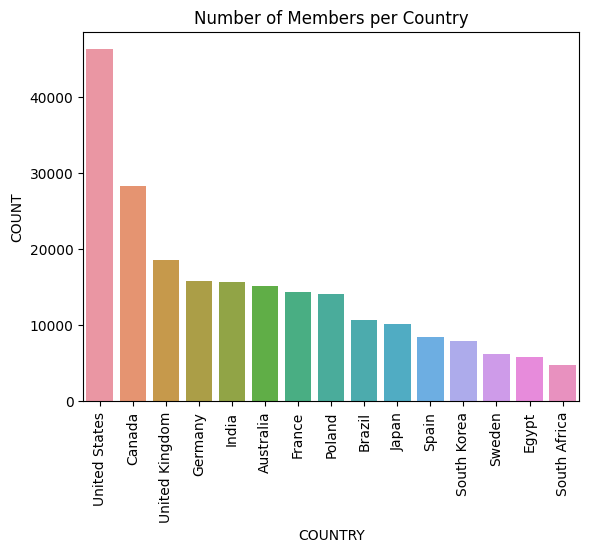

In [265]:
#Unique members
temp_df=tasty_bytes_customer_loyalty.group_by(F.col('Country')).count().to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=temp_df)
plt.xticks(rotation=90)
plt.title('Number of Members per Country')
plt.show()

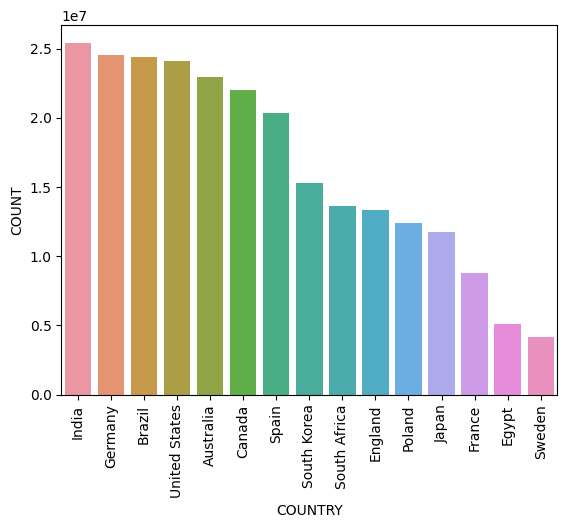

In [266]:
#Number of unique transactions
temp_df=tasty_bytes_orders_v.group_by(F.col('COUNTRY')).agg(F.countDistinct('ORDER_ID').alias('COUNT')).to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=temp_df)
plt.xticks(rotation=90)
plt.title('')
plt.show()

In [267]:
#Get last transaction date for each country
last_tran_country = tasty_bytes_orders_v.group_by(F.col('COUNTRY')).max(F.to_date(F.col('ORDER_TS'))).to_pandas()

#Get assumed churned date which is two weeks before last transaction date, then get total number of customers in the assumed time period
last_tran_country['CHURN_DATE']=last_tran_country['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=14)
last_tran_country['CUSTOMER_COUNT_DATE']=last_tran_country['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=44)

#Make pandas dataframe into a snowpark dataframe
last_tran_country_sdf=session.createDataFrame(last_tran_country)

#Merge 
last_tran_country_sdf_join = last_tran_country_sdf.join(
    right=tasty_bytes_orders_v,
    on="COUNTRY",
    how="inner"
)


#Filter dataframe to the assumed time period
df = last_tran_country_sdf_join[last_tran_country_sdf_join["DATE"] > last_tran_country_sdf_join["CUSTOMER_COUNT_DATE"]]
df.show()

#Filter to get churned members dataset
df2 = df[last_tran_country_sdf_join["DATE"] > last_tran_country_sdf_join["CHURN_DATE"]]

#Number of customers before churn date
cust_bef = df.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_BEF'))
#Number of customers after churn date
cust_aft = df2.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_AFT'))

#Merge
calculator = cust_aft.join(
    right=cust_bef,
    on="COUNTRY",
    how="inner"
)
calc = calculator.to_pandas()

#Calculate Churn rate 
calc["CHURN_RATE"] = (((calc["COUNT_BEF"] - calc["COUNT_AFT"]) / calc["COUNT_BEF"]) * 100)
temp_df=calc.sort_values(by='CHURN_RATE',ascending=False)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"COUNTRY"  |"MAX(TO_DATE(ORDER_TS))"  |"CHURN_DATE"  |"CUSTOMER_COUNT_DATE"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK_BRAND_NAME"  |"MENU_TYPE"   |"PRI

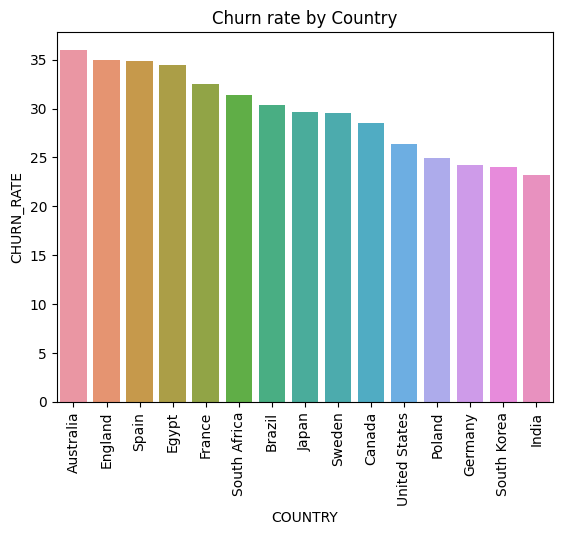

In [268]:
#Churn rate by Country
sns.barplot(x='COUNTRY',y='CHURN_RATE',data=temp_df)
plt.xticks(rotation=90)
plt.title('Churn rate by Country')
plt.show()

We decided to work on United States as it has the most number of customers, a high number of customers and quite a high Churn Rate.

## Preparing the table for Modelling

In [269]:
#Merge to get loyal customers orders
loyal_customer_orders=tasty_bytes_orders_v.join(
    right=tasty_bytes_customer_loyalty,
    on="CUSTOMER_ID",
    how="inner"
)
loyal_customer_orders.show()
print('Number of rows:',loyal_customer_orders.count())

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [270]:
#Function to remove and rename columns after inner join
def remove_dup_join_col(df):
    # capitalise all columns
    for col in df.columns:
        df = df.withColumnRenamed(col, col.upper())
    
    # get list of renamable columns for left and right join
    left_dup_col = [col_name for col_name in df.columns if col_name.startswith('L_')]
    right_dup_col = [col_name for col_name in df.columns if col_name.startswith('R_')]
    old_columns = df.columns
    
    # rename the list with the most number of renamable columns
    # drop the list of columns with less number of renamable columns
    if len(left_dup_col)>len(right_dup_col):
        columns_rename=left_dup_col
        df= df.drop(*right_dup_col)
    else:
        columns_rename=right_dup_col
        df= df.drop(*left_dup_col)
    
    for old_column in old_columns:
        if old_column in columns_rename:
            # get string to remove
            string_to_replace = columns_rename[0][:7]
            # replace starting string
            new_column = old_column.replace(string_to_replace, "")
            df = df.withColumnRenamed(old_column, new_column)
    
    return df

In [271]:
#Remove duplicate columns
loyal_customer_orders = remove_dup_join_col(loyal_customer_orders)
loyal_customer_orders.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NU

In [272]:
#Remove duplicate order ids
remove_dup = loyal_customer_orders.dropDuplicates(['ORDER_ID'])
remove_dup.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_I

In [273]:
# assuming you have a DataFrame called `orders` with columns `customer_id` and `order_ts`
window_spec = Window.partitionBy('customer_id').orderBy(F.col('order_ts').desc())

orders_with_rank = remove_dup.withColumn('rank', F.rank().over(window_spec))

#Get max order of each customer
max_order_ts = orders_with_rank.filter(F.col('rank') == 1).select('customer_id', 'order_ts')

#Get second max order of each customer
second_max_order_ts = orders_with_rank.filter(F.col('rank') == 2).select('customer_id', 'order_ts')


In [274]:
#Rename columns
second_max_order_ts = second_max_order_ts.withColumnRenamed('ORDER_TS','2ndMax_Order_TS')
max_order_ts = max_order_ts.withColumnRenamed('ORDER_TS','Max_Order_TS')

In [275]:
#Merge with second max order dataframe
temp_df=remove_dup.join(right=second_max_order_ts,on='CUSTOMER_ID',how='inner')

#Filter out last purchase
filtered_df = temp_df.filter(F.col('ORDER_TS') <= F.col('2ndMax_Order_TS'))

### Feature Engineering: Adding RFM Columns

In [276]:
#Display last purchase
tasty_bytes_orders_v.select(F.max('ORDER_TS')).show()

-----------------------
|"MAX(""ORDER_TS"")"  |
-----------------------
|2022-11-01 22:59:59  |
-----------------------



In [277]:
#Get last purchase date as a variable
lastdate=tasty_bytes_orders_v.select(F.max('ORDER_TS')).first()[0]

# Recency
recency = filtered_df.groupBy('CUSTOMER_ID').agg(F.max('ORDER_TS').alias('ORDER_TS'))
recency = recency.withColumn('RECENCY', F.datediff(col1=F.col('ORDER_TS'), col2=F.lit(lastdate),part='day'))

# Frequency
frequency = filtered_df.groupBy('CUSTOMER_ID').agg(F.countDistinct('ORDER_ID').alias('frequency'))

# Monetary
monetary = filtered_df.groupBy('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('monetary'))

# Merge into RFM table
RFM_table = recency.join(frequency, on='CUSTOMER_ID', how='inner')
RFM_table = RFM_table.join(monetary, on='CUSTOMER_ID', how='inner')

### Feature Engineering: Adding Average Time Difference, Max and Min Days without Purchase

In [278]:
# Define a window partitioned by customer and menu item, ordered by date
window_spec = Window.partitionBy("CUSTOMER_ID").orderBy("DATE")

# Add a column with the date of the prior order for each customer and menu item
orders_df = filtered_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.lag("DATE").over(window_spec))

# Calculate the number of days between the prior order and the current order for each customer and menu item
orders_df = orders_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.datediff(col1="DAYS_SINCE_PRIOR_ORDER", col2="DATE",part='day'))
orders_df = orders_df.na.drop(subset=["DAYS_SINCE_PRIOR_ORDER"])

#Calculate the average purchase time difference for each customer
avg_time_diff=orders_df.group_by('CUSTOMER_ID').agg(F.round(F.avg('DAYS_SINCE_PRIOR_ORDER'),0).alias('Avg_Days_Between_Purchase'))

# Max Days without Purchase
max_days=orders_df.group_by('CUSTOMER_ID').agg(F.max('DAYS_SINCE_PRIOR_ORDER').alias('Max_Days_Without_Purchase'))

# Min Days without Purchase
min_days=orders_df.group_by('CUSTOMER_ID').agg(F.min('DAYS_SINCE_PRIOR_ORDER').alias('Min_Days_Without_Purchase'))

### Feature Engineering Categorical Variables

In [279]:
#Get Customer demographic
cust_demo=tasty_bytes_customer_loyalty.select('CUSTOMER_ID','BIRTHDAY_DATE','GENDER','MARITAL_STATUS','COUNTRY')

# get AGE variable
cust_demo = cust_demo.withColumn("AGE", F.datediff('year', F.col("BIRTHDAY_DATE"),F.lit(lastdate)))

cust_demo.show()


--------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"BIRTHDAY_DATE"  |"GENDER"     |"MARITAL_STATUS"  |"COUNTRY"      |"AGE"  |
--------------------------------------------------------------------------------------------
|66             |1982-11-24       |Male         |Married           |Canada         |40     |
|118            |1988-06-13       |Male         |Single            |United States  |34     |
|131            |1984-12-29       |Male         |Single            |Canada         |38     |
|132            |1981-04-30       |Male         |Single            |Canada         |41     |
|171            |1987-08-06       |Male         |Single            |Canada         |35     |
|189            |1984-03-05       |Undisclosed  |Married           |United States  |38     |
|195            |1987-08-17       |Female       |Single            |Canada         |35     |
|204            |1979-06-25       |Male         |Undisclosed       |Un

In [280]:
#Merge to get final dataframe
final_df = RFM_table.join(max_order_ts, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(avg_time_diff, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(max_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(min_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(cust_demo,on='CUSTOMER_ID',how='inner')

In [281]:
#Convert timestamp to date such that Days to next orders is more accurate
final_df=final_df.with_column('ORDER_TS',F.to_date(F.col('ORDER_TS')))
final_df=final_df.with_column('MAX_ORDER_TS',F.to_date(F.col('MAX_ORDER_TS')))

In [282]:
#Add Days To Next Order
final_df = final_df.withColumn('Days_To_Next_Order', F.datediff(col1=final_df['ORDER_TS'], col2=final_df['MAX_ORDER_TS'],part='day'))
#final_df['Days_To_Next_Order']=(final_df['MAX_ORDER_TS']-final_df['ORDER_TS']).dt.days

In [283]:
#Get median of Days to next order
final_df.select(F.median('DAYS_TO_NEXT_ORDER')).show()

------------------------------------
|"MEDIAN(""DAYS_TO_NEXT_ORDER"")"  |
------------------------------------
|9.000                             |
------------------------------------



*We'll create a target variable based on whether customers purchase below or above the median number of days since their prior order. 'Not churn' will indicate purchases below the median, while 'Churn' will represent purchases above the median. This helps identify customers for retention strategies and predicts their engagement with our business.

In [284]:
#Filter to United States
final_df=final_df.filter(F.col('COUNTRY')=='United States')

In [285]:
#Convert to pandas
final_df=final_df.to_pandas()

In [286]:
final_df

,CUSTOMER_ID,RECENCY,FREQUENCY,MONETARY,AVG_DAYS_BETWEEN_PURCHASE,MAX_DAYS_WITHOUT_PURCHASE,MIN_DAYS_WITHOUT_PURCHASE,BIRTHDAY_DATE,GENDER,MARITAL_STATUS,COUNTRY,AGE,ORDER_TS,MAX_ORDER_TS,DAYS_TO_NEXT_ORDER
0,61792,31,27,1002.00,29,92,2,1997-12-11,Female,Undisclosed,United States,25,2022-10-01,2022-10-20,19
1,141268,4,54,1902.75,19,95,1,1943-09-13,Female,Divorced/Seperated,United States,79,2022-10-28,2022-10-29,1
2,100865,21,54,2195.50,24,143,1,1954-04-26,Male,Single,United States,68,2022-10-11,2022-10-17,6
3,145521,7,54,2156.75,19,111,1,2001-02-22,Male,Married,United States,21,2022-10-25,2022-10-29,4
4,59116,21,43,1664.75,30,193,1,1974-10-29,Female,Undisclosed,United States,48,2022-10-11,2022-10-22,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46295,191946,11,58,2115.50,23,220,1,1963-08-09,Male,Single,United States,59,2022-10-21,2022-10-24,3
46296,148021,11,49,1967.50,21,171,1,1950-01-14,Male,Married,United States,72,2022-10-21,2022-10-25,4
46297,125450,9,47,1848.75,24,163,1,1999-04-11,Undisclosed,Married,United States,23,2022-10-23,2022-10-30,7
46298,114559,14,56,1760.00,18,68,1,1962-02-11,Male,Divorced/Seperated,United States,60,2022-10-18,2022-10-23,5


### Outlier Handling

In [287]:
num_cols=final_df.select_dtypes(exclude=['object','datetime64[ns]']).columns.drop('CUSTOMER_ID')

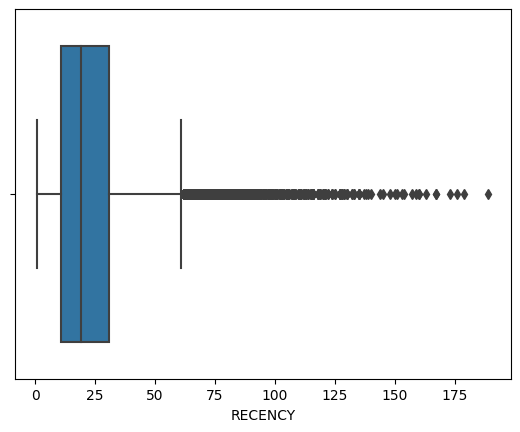

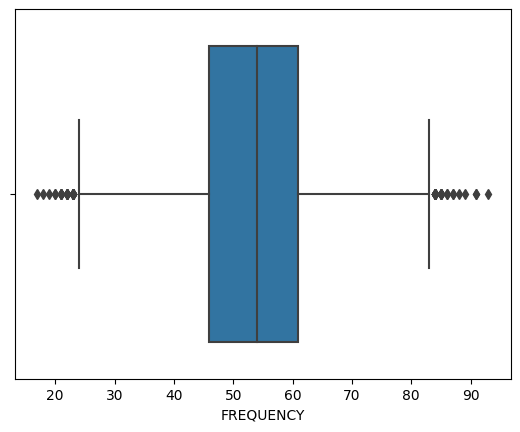

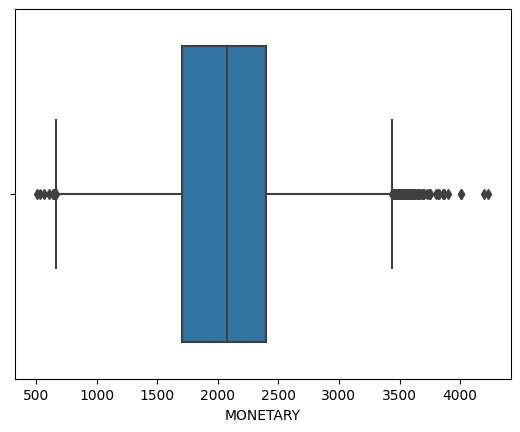

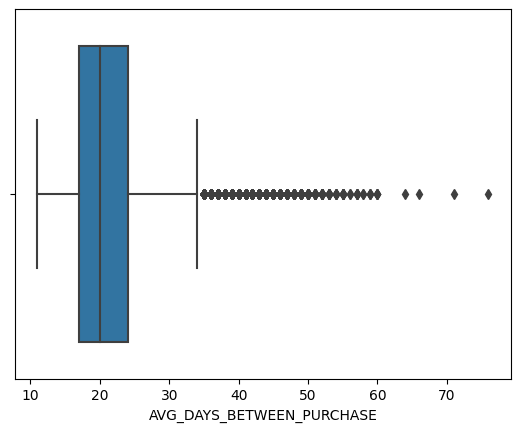

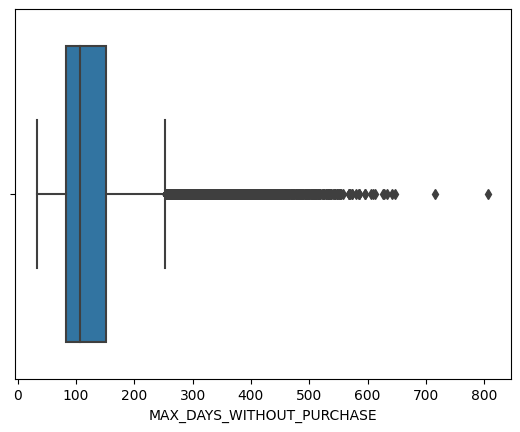

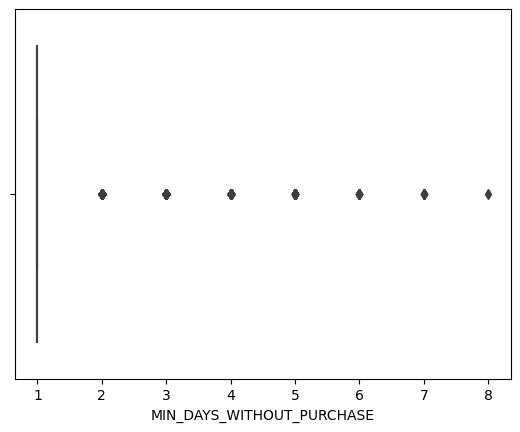

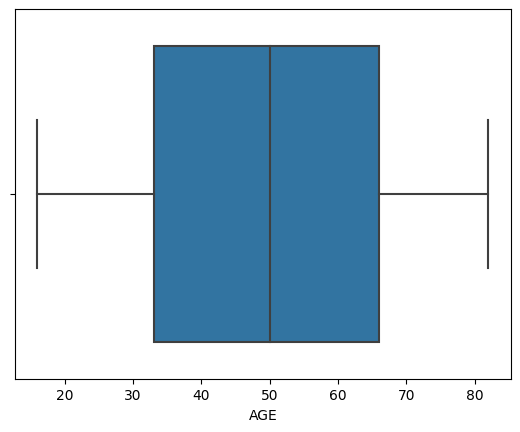

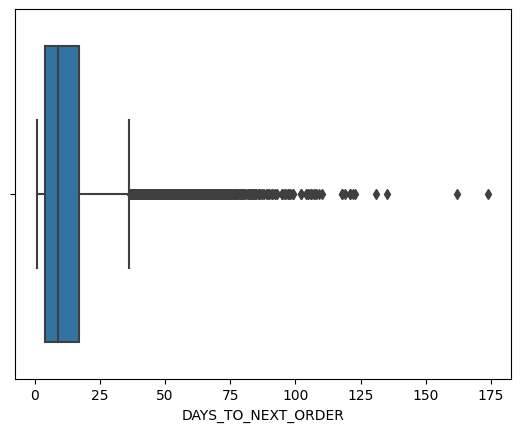

In [288]:
for i in num_cols:
    sns.boxplot(data=final_df,x=final_df[i])
    plt.show()

In [289]:
from feature_engine.outliers import Winsorizer
# create the capper
windsorizer = Winsorizer(capping_method='iqr', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['RECENCY','AVG_DAYS_BETWEEN_PURCHASE','MAX_DAYS_WITHOUT_PURCHASE'])

windsorizer.fit(final_df)


Winsorizer(capping_method='iqr', tail='both',
           variables=['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE',
                      'MAX_DAYS_WITHOUT_PURCHASE'])

*Note there is no point dealing with outliers in Days to next order as even when dealt with, the 50% mark stays the same, meaning no change to our target variable.

In [290]:
final_df_win = windsorizer.transform(final_df)

In [291]:
# create the capper
windsorizer = Winsorizer(capping_method='gaussian', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['FREQUENCY','RECENCY'])

windsorizer.fit(final_df_win)

Winsorizer(tail='both', variables=['FREQUENCY', 'RECENCY'])

In [292]:
final_df_win = windsorizer.transform(final_df_win)

### Numerical Transformation

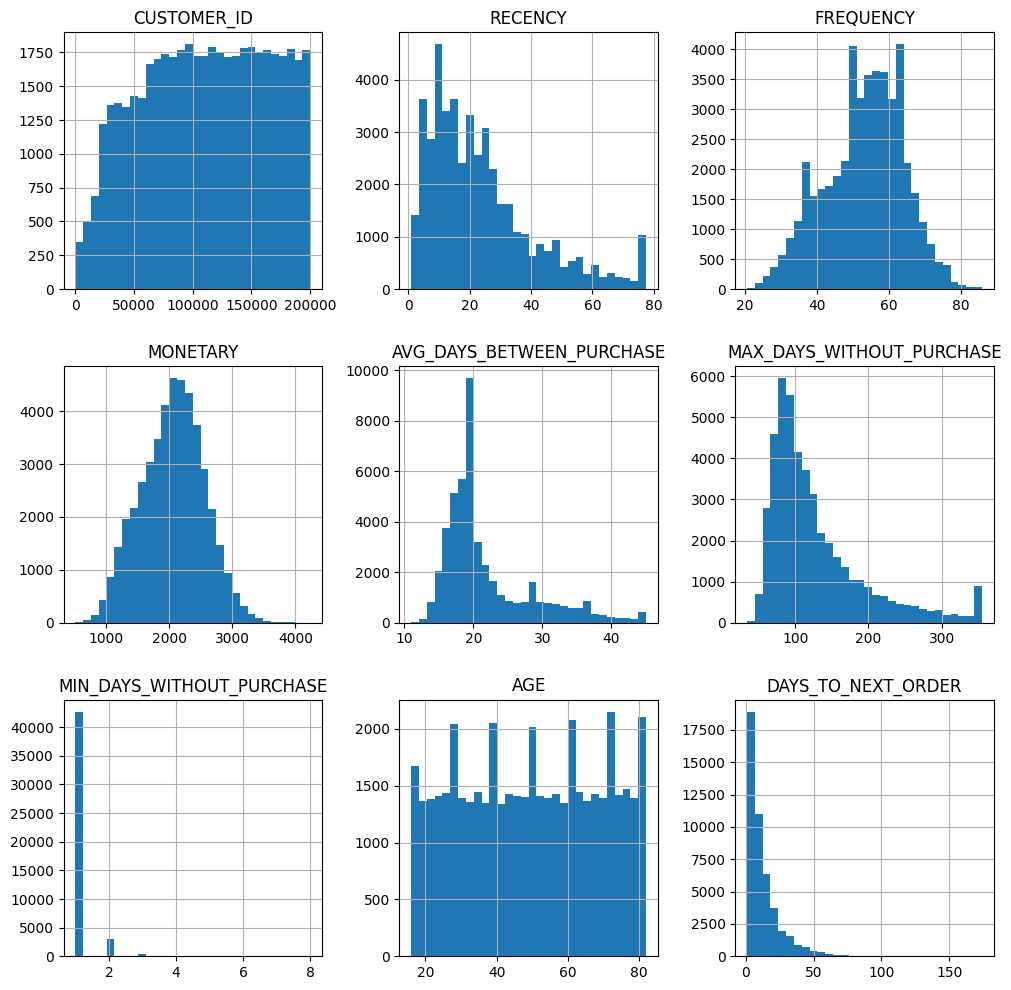

In [293]:
# plot the histogram to inspect variable distributions (not in book)

final_df_win.hist(bins=30, figsize=(12,12))
plt.show()

In [294]:
# from feature_engine.transformation import YeoJohnsonTransformer

# # select variables to transform in a list
# cols = ['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE', 'MAX_DAYS_WITHOUT_PURCHASE', 'MIN_DAYS_WITHOUT_PURCHASE']

# # initialize the transformer with a subset of variables to transform
# yjt = YeoJohnsonTransformer(variables = cols)

# # fit transformer to the dataframe
# yjt.fit(final_df_win)

In [295]:
# transform indicated variables
final_df_win = yjt.transform(final_df_win)

### One Hot Encoding

In [296]:
# #One Hot Encoding
# ohe_enc = OneHotEncoder(
#     top_categories=None,
#     drop_last=True)  # to return k-1, false to return k

# ohe_enc.fit(final_df_win)
# final_df_enc = ohe_enc.transform(final_df_win)


### Final Table

In [297]:
final_df_enc=final_df_win

In [298]:
#Describe the target
final_df_enc['DAYS_TO_NEXT_ORDER'].describe()

count    46300.000000
mean        12.572959
std         12.840417
min          1.000000
25%          4.000000
50%          9.000000
75%         17.000000
max        174.000000
Name: DAYS_TO_NEXT_ORDER, dtype: float64

In [299]:
#Add Target Variable Next Purchase Day Range 
final_df_enc['NextPurchaseDayRange'] = 1
final_df_enc.loc[final_df_enc['DAYS_TO_NEXT_ORDER']<=9,'NextPurchaseDayRange'] = 0

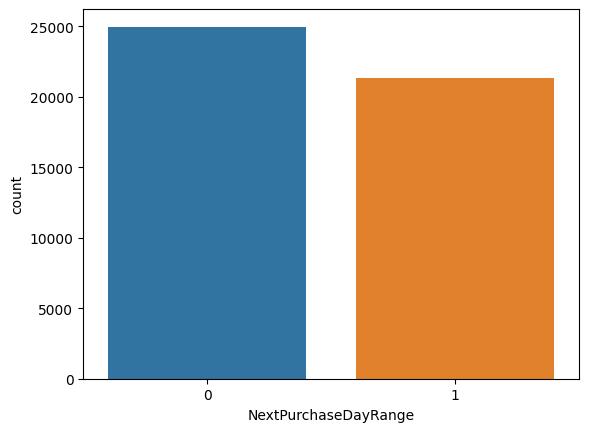

In [300]:
#Distribution of target variable
sns.countplot(data=final_df_enc,x='NextPurchaseDayRange')
plt.show()

### Train Test Split

In [301]:
df1=final_df_enc[final_df_enc['NextPurchaseDayRange']==1]
len(df1)

21328

In [302]:
df0=final_df_enc[final_df_enc['NextPurchaseDayRange']==0]
len(df0)

24972

In [303]:
#Perform Stratified Sampling
df0_sampled = df0.sample(n=len(df1), random_state=4).copy()
df_new=pd.concat([df1,df0_sampled],axis=0)
df_new['NextPurchaseDayRange'].value_counts()

1    21328
0    21328
Name: NextPurchaseDayRange, dtype: int64

In [304]:
#Train test split
X = df_new.drop(['DAYS_TO_NEXT_ORDER','MAX_ORDER_TS','ORDER_TS','FAVOURITE_BRAND_encode','GENDER_encode','MARITAL_STATUS_encode','BIRTHDAY_DATE'], axis =1,
                  errors='ignore')
y = df_new["NextPurchaseDayRange"]


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.6,random_state=4)

In [305]:
#Test and holdout split
X_test,X_holdout,y_test,y_holdout=train_test_split(X_test,y_test,test_size=0.5,random_state=4)

In [306]:
#One Hot Encoding 
ohe_enc = OneHotEncoder(
     top_categories=None,
     drop_last=True)  # to return k-1, false to return k

ohe_enc.fit(X_train)
X_train = ohe_enc.transform(X_train)
X_test=ohe_enc.transform(X_test)
X_holdout=ohe_enc.transform(X_holdout)

In [307]:
X_train

,CUSTOMER_ID,RECENCY,FREQUENCY,MONETARY,AVG_DAYS_BETWEEN_PURCHASE,MAX_DAYS_WITHOUT_PURCHASE,MIN_DAYS_WITHOUT_PURCHASE,AGE,NextPurchaseDayRange,GENDER_Male,GENDER_Female,MARITAL_STATUS_Married,MARITAL_STATUS_Divorced/Seperated,MARITAL_STATUS_Single
17718,97535,5.228435,42.0,1374.50,0.581798,1.588475,0.037138,81,1,1,0,1,0,0
32122,163104,2.507714,55.0,2151.50,0.580177,1.543885,0.037138,29,0,0,1,0,1,0
15119,153918,3.567674,81.0,4233.00,0.578574,1.559182,0.037138,44,0,0,1,0,0,1
25597,43161,4.982313,37.0,1596.75,0.581424,1.560319,0.037138,33,1,1,0,0,0,1
38942,175518,2.507714,54.0,2203.25,0.580177,1.533527,0.037138,82,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29436,85499,5.083954,53.0,2065.00,0.580696,1.560874,0.037138,34,0,0,1,0,0,0
25557,125643,4.646561,61.0,2172.50,0.579861,1.550131,0.037138,42,1,1,0,0,0,1
5303,144964,3.937159,51.0,2215.50,0.580453,1.563016,0.037138,65,0,1,0,0,1,0
18027,175749,5.133129,48.0,1777.00,0.580910,1.570067,0.037138,40,1,0,1,0,0,1


In [308]:
X_train.rename({'MARITAL_STATUS_Divorced/Seperated':'MARITAL_STATUS_Divorced_Or_Seperated'}, axis=1,inplace=True)
X_test.rename({'MARITAL_STATUS_Divorced/Seperated':'MARITAL_STATUS_Divorced_Or_Seperated'}, axis=1,inplace=True)
X_holdout.rename({'MARITAL_STATUS_Divorced/Seperated':'MARITAL_STATUS_Divorced_Or_Seperated'}, axis=1,inplace=True)

In [309]:
X_train.columns = map(str.upper, X_train.columns)
X_test.columns = map(str.upper, X_test.columns)
X_holdout.columns = map(str.upper, X_holdout.columns)

In [310]:
#Save tables to snowflake
session.create_dataframe(X_train).write.save_as_table(table_name="train_table", mode='overwrite')
session.create_dataframe(X_test).write.save_as_table(table_name="test_table", mode='overwrite')
session.create_dataframe(X_holdout).write.save_as_table(table_name="holdout_table", mode='overwrite')

c:\Users\donsu\.conda\envs\py38_env\lib\site-packages\snowflake\snowpark\session.py:1346: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.numeric.Int64Index'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success, nchunks, nrows, ci_output = write_pandas(


In [311]:
X_train=X_train.drop('NEXTPURCHASEDAYRANGE',axis=1, errors='ignore')
X_test=X_test.drop('NEXTPURCHASEDAYRANGE',axis=1, errors='ignore')
X_holdout=X_holdout.drop('NEXTPURCHASEDAYRANGE',axis=1, errors='ignore')

### Feature Scaling

In [312]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

#transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_holdout_scaled=scaler.transform(X_holdout)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_houldout_scaled=pd.DataFrame(X_holdout_scaled,columns=X_holdout.columns)

## Model Building

## Define Evaluation Function

In [313]:
#Function to show MSE, MAE, r-sq of Classification models
def evaluateModel(model):
    #Accuracy
    print('Train Accuracy:',model.score(X_train, y_train),
          '\nTest Accuracy:',model.score(X_test, y_test),
          '\nHoldout Accuracy:',model.score(X_holdout, y_holdout))

In [314]:
#Function to show MSE, MAE, r-sq of Classification models
def evaluateModelWithName(model,model_name):
    print(model_name)
    print('Train Accuracy:',model.score(X_train, y_train),
          '\nTest Accuracy:',model.score(X_test, y_test),
          '\n')

## Models

### Logistic Regression

#### Build the model

In [315]:
#Build Logistic Regression Model
log_ref_before = LogisticRegression(max_iter=10000)
log_ref_before.fit(X_train, y_train)

evaluateModel(log_ref_before)

Train Accuracy: 0.539444379322471 
Test Accuracy: 0.5342658435570837 
Holdout Accuracy: 0.5415331718371493


#### Improve the model

In [316]:
# Task 1: Use GridSearch to find the best combination of model hyperparameters

logreg = LogisticRegression()
param_grid = {"penalty": ["l2"],
                "C" : [0.1, 1, 10],
                "solver" : ["newton-cg", "lbfgs", "liblinear"]}

gs =GridSearchCV(logreg, param_grid = param_grid, scoring = "accuracy", cv = 10, n_jobs = -1)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

c:\Users\donsu\.conda\envs\py38_env\lib\site-packages\scipy\optimize\_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\donsu\.conda\envs\py38_env\lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


0.768198391424594
{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}


c:\Users\donsu\.conda\envs\py38_env\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [317]:
#Build Logistic Regression Model
log_ref_improved = LogisticRegression(**gs.best_params_)
log_ref_improved.fit(X_train, y_train)

evaluateModel(log_ref_improved)

c:\Users\donsu\.conda\envs\py38_env\lib\site-packages\scipy\optimize\_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\donsu\.conda\envs\py38_env\lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Train Accuracy: 0.7683741648106904 
Test Accuracy: 0.7686176447604908 
Holdout Accuracy: 0.7694772212237243


c:\Users\donsu\.conda\envs\py38_env\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


## Decision Tree

#### Build the model

In [318]:
#Build Decision Tree Model
decision_tree_before = tree.DecisionTreeClassifier(max_depth = 20)

decision_tree_before.fit(X_train, y_train)

evaluateModel(decision_tree_before)

Train Accuracy: 0.9318368303833079 
Test Accuracy: 0.7041494100179729 
Holdout Accuracy: 0.7068062827225131


#### Improve the model

In [319]:
dt = tree.DecisionTreeClassifier(max_depth = 2)

param_grid = { "criterion" : ["gini", "entropy"], 
              "min_samples_leaf" : [1, 5, 10,20,30,40,50,100], 
              "min_samples_split" : [2, 4, 10, 12, 16], 
              'max_depth' : [2,3,4,5,6,7]}

gs = GridSearchCV(dt, param_grid=param_grid, scoring='accuracy', cv= 10, n_jobs=-1)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors

gs = gs.fit(X_train, y_train) 

print(gs.best_score_)
print(gs.best_params_)

0.7775173394703968
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [320]:
# Create Decision Tree using the best hyperparameters
decision_tree_improved = tree.DecisionTreeClassifier(**gs.best_params_)
decision_tree_improved.fit(X_train, y_train)

evaluateModel(decision_tree_improved)

Train Accuracy: 0.7775172898839526 
Test Accuracy: 0.7760412596702352 
Holdout Accuracy: 0.7722122372431038


### Random Forest

#### Build the model

In [321]:
#Build Random Forest Model

random_forest_before= RandomForestClassifier(n_estimators=100)
random_forest_before.fit(X_train, y_train)

evaluateModel(random_forest_before)

Train Accuracy: 1.0 
Test Accuracy: 0.7715870907243886 
Holdout Accuracy: 0.7666640618895053


#### Improve the model

In [322]:
rf = RandomForestClassifier()
param_grid = {'n_estimators': [1, 10, 50, 100],
'max_depth': [2, 4, 6, 8, 10],
'min_samples_split': [2, 5, 10, 15, 20]}

gs = GridSearchCV(rf, param_grid = param_grid, scoring = "accuracy", cv = 10, n_jobs = -1)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.7782204988630363
{'max_depth': 8, 'min_samples_split': 15, 'n_estimators': 50}


In [323]:
# Build RandomForest Model and Evaluate both training and testing accuracy
random_forest_improved = RandomForestClassifier(**gs.best_params_)
random_forest_improved.fit(X_train,y_train)

evaluateModel(random_forest_improved)

Train Accuracy: 0.7840229750322354 
Test Accuracy: 0.776197546299914 
Holdout Accuracy: 0.772993670391498


## Adaboost

In [324]:
#Build Ada Boost Model
adb_before = AdaBoostClassifier(DecisionTreeClassifier(),n_estimators=5,learning_rate=1)
adb_before.fit(X_train, y_train)

evaluateModel(adb_before)

Train Accuracy: 1.0 
Test Accuracy: 0.6887551769946081 
Holdout Accuracy: 0.6841447214190826


In [325]:
# Without Outlier Handling
# Train Accuracy: 1.0 
# Test Accuracy: 0.6900836133468782 
# Holdout Accuracy: 0.6907869031804329

In [326]:
# With Numerical Transformation
# Train Accuracy: 1.0 
# Test Accuracy: 0.6844572946784403 
# Holdout Accuracy: 0.6900054700320387

In [327]:
adb = AdaBoostClassifier()

param_grid = {
    'estimator': [tree.DecisionTreeClassifier(max_depth=1), tree.DecisionTreeClassifier(max_depth=2)],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R']
}

gs = GridSearchCV(adb, param_grid, cv=5, n_jobs=-1)

gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.7782793807141785
{'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.1, 'n_estimators': 200}


In [328]:
#Task 2: Build Ada Boost Model and Evaluate both training and testing accuracy
adb_improved = AdaBoostClassifier(**gs.best_params_)
adb_improved.fit(X_train,y_train)

evaluateModel(adb_improved)

Train Accuracy: 0.7783378267495018 
Test Accuracy: 0.7750253965773228 
Holdout Accuracy: 0.7728373837618192


In [329]:
# Without Outlier Handling
# Train Accuracy: 0.7796858516000469 
# Test Accuracy: 0.7742439634289286 
# Holdout Accuracy: 0.7740876767992498

In [330]:
# With Numerical Transformation
# Train Accuracy: 0.7771656312272888 
# Test Accuracy: 0.7759631163553958 
# Holdout Accuracy: 0.7737751035398922

## XGboost

In [331]:
#Build XGBoost Model
xgb_before = XGBClassifier(n_estimators = 20, learning_rate = 0.1, eval_metric='logloss',max_depth = 20)
xgb_before.fit(X_train, y_train)

#Evaluate XGBoost Model
evaluateModel(xgb_before)

Train Accuracy: 0.9705778923924511 
Test Accuracy: 0.7591623036649214 
Holdout Accuracy: 0.757755723997812


In [332]:
#After outlier handling
# Train Accuracy: 0.9708123314968937 
# Test Accuracy: 0.7601000234429944 
# Holdout Accuracy: 0.7544737047745566

In [333]:
# With Numerical Transformation
# Train Accuracy: 0.9706365021685617 
# Test Accuracy: 0.7561147143861843 
# Holdout Accuracy: 0.7561147143861843

In [334]:
xgb = XGBClassifier()

param_grid = {
    'max_depth': [4, 6, 8], 
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'n_estimators': [20, 50, 100, 200],
    'objective': ['binary:logistic'],
    'n_jobs': [-1]
}

gs = GridSearchCV(xgb, param_grid, cv=5, n_jobs=-1)

gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.7775760839957833
{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 20, 'n_jobs': -1, 'objective': 'binary:logistic'}


In [335]:
# Task 3: Build XGBoost Model and Evaluate both training and testing accuracy 
xgb_improved = XGBClassifier(**gs.best_params_)
xgb_improved.fit(X_train,y_train)

evaluateModel(xgb_improved)

Train Accuracy: 0.778982534286719 
Test Accuracy: 0.7765101195592717 
Holdout Accuracy: 0.7722122372431038


In [336]:
#After outlier handling
# Train Accuracy: 0.7800375102567109 
# Test Accuracy: 0.7773696960225053 
# Holdout Accuracy: 0.7727592404469797

In [337]:
# With Numerical Transformation
# Train Accuracy: 0.7789239245106083 
# Test Accuracy: 0.7752598265218411 
# Holdout Accuracy: 0.7744783933734469

In [338]:
from sklearn.metrics import classification_report
print(classification_report(y_test,xgb_improved.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.66      0.74      6291
           1       0.73      0.89      0.80      6506

    accuracy                           0.78     12797
   macro avg       0.79      0.77      0.77     12797
weighted avg       0.79      0.78      0.77     12797



#### Improve the Model

# Model Evaulation

In [339]:
evaluateModelWithName(log_ref_before,'log_ref_before')
evaluateModelWithName(log_ref_improved,'log_ref_improved')

evaluateModelWithName(decision_tree_before,'decision_tree_before')
evaluateModelWithName(decision_tree_improved,'decision_tree_improved')

evaluateModelWithName(random_forest_before,'log_ref_before')
evaluateModelWithName(random_forest_improved,'log_ref_before')

evaluateModelWithName(adb_before,'adb_before')
evaluateModelWithName(adb_improved,'adb_improved')

evaluateModelWithName(xgb_before,'xgb_before')
evaluateModelWithName(xgb_improved,'xgb_improved')


log_ref_before
Train Accuracy: 0.539444379322471 
Test Accuracy: 0.5342658435570837 

log_ref_improved
Train Accuracy: 0.7683741648106904 
Test Accuracy: 0.7686176447604908 

decision_tree_before
Train Accuracy: 0.9318368303833079 
Test Accuracy: 0.7041494100179729 

decision_tree_improved
Train Accuracy: 0.7775172898839526 
Test Accuracy: 0.7760412596702352 

log_ref_before
Train Accuracy: 1.0 
Test Accuracy: 0.7715870907243886 

log_ref_before
Train Accuracy: 0.7840229750322354 
Test Accuracy: 0.776197546299914 

adb_before
Train Accuracy: 1.0 
Test Accuracy: 0.6887551769946081 

adb_improved
Train Accuracy: 0.7783378267495018 
Test Accuracy: 0.7750253965773228 

xgb_before
Train Accuracy: 0.9705778923924511 
Test Accuracy: 0.7591623036649214 

xgb_improved
Train Accuracy: 0.778982534286719 
Test Accuracy: 0.7765101195592717 



In [340]:
log_ref_before
Train Accuracy: 0.7572383073496659 
Test Accuracy: 0.7494725326248339 

log_ref_improved
Train Accuracy: 0.7580588442152151 
Test Accuracy: 0.7500976791435493 

decision_tree_before
Train Accuracy: 0.9338295627710702 
Test Accuracy: 0.7128233179651481 

decision_tree_improved
Train Accuracy: 0.7802719493611534 
Test Accuracy: 0.7760412596702352 

log_ref_before
Train Accuracy: 1.0 
Test Accuracy: 0.7697897944830819 

log_ref_before
Train Accuracy: 0.7794514124956042 
Test Accuracy: 0.7758849730405564 

adb_before
Train Accuracy: 1.0 
Test Accuracy: 0.6928967726810972 

adb_improved
Train Accuracy: 0.7782792169733912 
Test Accuracy: 0.7757286864108776 

xgb_before
Train Accuracy: 0.9704606728402297 
Test Accuracy: 0.7595530202391185 

xgb_improved
Train Accuracy: 0.7800961200328215 
Test Accuracy: 0.7772134093928265 


SyntaxError: invalid syntax (2058292476.py, line 2)

# Data evaluation

In [ ]:
#Check top 10 features based on feature importance
ft_weights_xgb_clf = pd.DataFrame(xgb_improved.feature_importances_, columns=['is_promoted'], index=X_train.columns)
ft_weights_xgb_clf.sort_values('is_promoted', ascending=False, inplace=True)
ft_weights_xgb_clf.tail(100)

,is_promoted
RECENCY,0.857821
AVG_DAYS_BETWEEN_PURCHASE,0.021916
MARITAL_STATUS_Undisclosed,0.019856
MAX_DAYS_WITHOUT_PURCHASE,0.018195
MONETARY,0.016944
GENDER_Male,0.015732
CUSTOMER_ID,0.015638
FREQUENCY,0.015019
MARITAL_STATUS_Divorced/Seperated,0.010874
AGE,0.008005


In [ ]:
thresholds = np.sort(xgb_improved.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgb_improved, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train.to_numpy())
    # train model
    selection_model = XGBClassifier(**gs.best_params_)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test.to_numpy())
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=13, Accuracy: 77.74%
Thresh=0.000, n=13, Accuracy: 77.74%
Thresh=0.000, n=13, Accuracy: 77.74%
Thresh=0.008, n=10, Accuracy: 77.74%
Thresh=0.011, n=9, Accuracy: 77.74%
Thresh=0.015, n=8, Accuracy: 77.67%
Thresh=0.016, n=7, Accuracy: 77.67%
Thresh=0.016, n=6, Accuracy: 77.69%
Thresh=0.017, n=5, Accuracy: 77.67%
Thresh=0.018, n=4, Accuracy: 77.69%
Thresh=0.020, n=3, Accuracy: 77.66%
Thresh=0.022, n=2, Accuracy: 77.64%
Thresh=0.858, n=1, Accuracy: 77.60%


## Reset

In [ ]:
"""# Drop training table
session.sql("DROP TABLE IF EXISTS frostbyte_tasty_bytes.analytics.shift_sales_train").collect()

# Drop testing table
session.sql("DROP TABLE IF EXISTS frostbyte_tasty_bytes.analytics.shift_sales_test").collect()

# Drop training stored procedure
session.sql("DROP PROCEDURE IF EXISTS sproc_train_linreg(varchar, array, varchar, varchar)").collect()

# Drop inference user-defined function
session.sql(
    "DROP FUNCTION IF EXISTS udf_linreg_predict_location_sales(float, float, float, float, float, float, float, float)"
).collect()

# Drop stage
session.sql("DROP STAGE IF EXISTS model_stage").collect()

# Scale down compute
session.sql("ALTER WAREHOUSE tasty_ds_wh SET WAREHOUSE_SIZE = XSMALL").collect()

# Close the session
session.close()"""